In [2]:
import os
os.environ['http_proxy'] = "http://127.0.0.1:12639" 
os.environ['https_proxy'] = "http://127.0.0.1:12639"

In [341]:
import torch
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pkbar
import time
import random

import tensorly as tl
from tensorly.decomposition import matrix_product_state, parafac
from tensorly.mps_tensor import mps_to_tensor
from tensorly.base import unfold, fold
from tensorly.kruskal_tensor import kruskal_to_tensor
tl.set_backend('pytorch')

import tensornetwork as tn
from tensornetwork import contractors
backend = 'pytorch'

In [4]:
def random_mask(length, ratio=0.7):
    keep = []
    while len(keep) < int(ratio * length):
        keep.append(random.randint(0, length - 1))
        keep = list(set(keep))
    return keep

In [5]:
s, a = 25, 4

# states: scan from left to right
# actions: left, right, top, down

R = torch.zeros((s, a)) 
for i in range(s):
    if i % 5 == 0:
        R[i, 0] = -1
    if (i - 4) % 5 == 0:
        R[i, 1] = -1
    if i in range(5):
        R[i, 2] = -1
    if i in range(s - 5, s):
        R[i, 3] = -1
R[1, :] = 10
R[3, :] = 5

R_vec = R.reshape(s * a)

In [6]:
# s_t, a, s_(t+1)
P = torch.zeros((s, a, s)) 
for i in range(s):
    if i % 5 == 0:
        P[i, 0, i] = 1
    if (i - 4) % 5 == 0:
        P[i, 1, i] = 1
    if i in range(5):
        P[i, 2, i] = 1
    if i in range(s - 5, s):
        P[i, 3, i] = 1    

    for j in range(s):
        if j == i - 1:
            P[i, 0, j] = 1
        if j == i + 1:
            P[i, 1, j] = 1
        if j == i - 5:
            P[i, 2, j] = 1
        if j == i + 5:
            P[i, 3, j] = 1
    if i == 1:        
        P[i, :, :] = 0
        P[i, :, 21] = 1
    if i == 3:
        P[i, :, :] = 0
        P[i, :, 13] = 1

In [7]:
P_mat = torch.empty((s, a, s, a))
for ss in range(s):
    for i in range(a):
        P_mat[:, :, ss, i] = P[:, :, ss]
P_mat = P_mat.reshape(s * a, s * a)

In [8]:
target = torch.tensor(
 [[21.97748529, 24.4194281, 21.97748529, 19.4194281, 17.47748529],
 [19.77973676, 21.97748529, 19.77973676, 17.80176308, 16.02158677],
 [17.80176308, 19.77973676, 17.80176308, 16.02158677, 14.4194281],
 [16.02158677, 17.80176308, 16.02158677, 14.4194281, 12.97748529],
 [14.4194281, 16.02158677, 14.4194281, 12.97748529, 11.67973676]])

In [192]:
class K_Spin(object):
    
    def __init__(self, s_size, a_size, k, data=None):
        '''
        args: 
            s_size: the cardinality of the state space
            a_size: the cardinality of the action space
            k: the number of interacting states
        '''
        super(K_Spin, self).__init__()
        self.k = k
        self.s_size = s_size
        self.a_size = a_size
        
        if data is not None:
            self.leaf = data
        else:
            self.leaf = torch.randn((s_size * a_size, 1))
            self.leaf.requires_grad = True
                
        self.data = self.softmax_by_state()
        self.qubits = self.create_qubits()
        self.outer_product_chain()

    
    def softmax_by_state(self):
        '''
        returns:
            updated data tensor after doing a softmax operation
            with regard to each of the states
        '''
        states = []
        softmax = torch.nn.Softmax(dim=0)
        for s in range(self.s_size):
            state = self.leaf[s * self.a_size : (s+1) * self.a_size, :]
            states.append(softmax(state))
        
        cat = torch.cat(states, dim=0) 
        return cat / torch.sum(cat)
        
        
    def outer_product_chain(self):
        '''
        modifies:
            connects the qubits into a tensor network that
            computes the outer product when contracted
        '''
        if self.k == 1:
            return
        self.qubits[0][1] ^ self.qubits[1][1]
        for k in range(1, self.k - 1):
            self.qubits[k][2] ^ self.qubits[k + 1][1]


    def create_qubits(self):
        '''
        returns:
            a list of qubits (nodes) with suitable dimensions
            (may contain dummy dimensions)
        '''
        qubits = []
        backend = 'pytorch'
        for i in range(self.k):
            if i == 0 or i == self.k - 1:
                q = tn.Node(self.data, backend=backend)
            else:
                q = tn.Node(self.data.unsqueeze(-1), backend=backend)
            qubits.append(q)
        return qubits

In [188]:
def initialize_H(k, P, R, s, a, mask, gamma=0.9):
    
    h = torch.zeros([s * a] * k, dtype=torch.float32)
    
    pbar = pkbar.Pbar(name='initialize H, k='+str(k), target=(s * a))
    for i in range(s * a):
        pbar.update(i)
        in_edge = torch.sum(P[..., i // a])
        
        if k == 1:
            if i in mask:
                h[i] = 1

        if k == 2:
            for j in range(s * a):
                if i in mask and j in mask:
                    h[i, j] = P_mat[i, j]
                
        if k == 3:
            for j in range(s * a):
                for l in range(s * a):
                    if i in mask and j in mask and l in mask:
                        h[i, j, l] = P_mat[i, j] * P_mat[j, l]
                    
        if k == 4:
            for j in range(s * a):
                for l in range(s * a):
                    for m in range(s * a):
                        if i in mask and j in mask and l in mask and m in mask:
                            h[i, j, l, m] = P_mat[i, j] * P_mat[j, l] * P_mat[l, m]
                        
        h[i, ...] *= in_edge
        
    for n in range(s * a):
        h[..., n] *= R_vec[n]
        
    h.requires_grad = False
    return tn.Node(h * gamma ** (k - 1), backend=backend)

In [454]:
def put_mps(tensors):
    '''
    returns
        a set of tensor cores connected in MPS
        a set of connected edges
    '''
    mps = []
    for i in range(len(tensors)):
        mps.append(tn.Node(tensors[i].detach().clone(), backend=backend))
    
    if len(tensors) == 1:
        return mps, []
    
    connected_edges=[]
    conn = mps[0][1] ^ mps[1][0]
    for k in range(1, len(tensors)-1):
        conn = mps[k][2] ^ mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges


def put_cp(factors):
    '''
    returns
        a set of tensor cores connected in cp
        a set of connected edges
    '''
    cp = []
    for f in factors:
        cp.append(tn.Node(f.detach().clone(), backend=backend))
    
    chi = factors[0].shape[1]
    core = torch.zeros([chi] * len(factors))
    for i in range(chi):
        index = tuple([i] * len(factors))
        core[index] = 1
    core = tn.Node(core, backend=backend)
    cp.append(core)
    
    connected_edges = []
    for k in range(len(factors)):
        conn = cp[k][1] ^ core[k]
        connected_edges.append(conn)

    return cp, connected_edges

In [457]:
a = torch.randn(100, 100, 100)
tensors, error = parafac(a, 50, n_iter_max=100, return_errors=True)
cp, _ = put_cp(tensors[1])
output_edges = []
for t in range(len(cp) - 1):
    output_edges.append(cp[t][0])
criterion = torch.nn.MSELoss()
a_prime = contractors.branch(tn.reachable(cp[0]), nbranch=1, output_edge_order=output_edges).get_tensor()
print(criterion(kruskal_to_tensor(tensors), a))
print(criterion(a_prime, a))
print(a_prime.shape)

tensor(0.9621)
tensor(0.9621)
torch.Size([100, 100, 100])


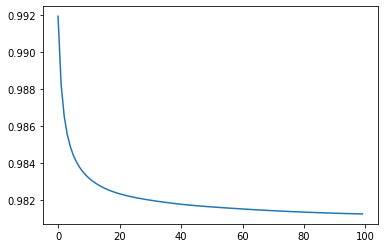

In [458]:
plt.plot(error)

In [420]:
core.get_tensor()

tensor([[1., 1.],
        [1., 1.]])

In [414]:
a_prime

tensor([[-0.0845,  0.1820],
        [ 0.8536, -1.8385]])

In [409]:
kruskal_to_tensor(tensors)

tensor([[ 0.0969,  1.5227],
        [-0.2618,  0.7224]])

In [22]:
def tensor_permutation(tensor, i):
    shape = [tensor.shape[l] for l in range(i, len(tensor.shape))] + \
            [tensor.shape[m] for m in range(i)]
    perm = torch.empty(shape)
    for j in range(tensor.shape[i]):
        perm[j, ...] = torch.index_select(tensor, i, torch.tensor([j])).squeeze()
    return perm

In [256]:
def tensor_grad_complete(mps, target, omega, lr=0.1, epochs=10000):
    losses = []
    criterion = torch.nn.MSELoss()
    op = optim.SGD(mps, lr=lr, momentum=0.9, weight_decay=5e-4)
    pbar = pkbar.Pbar(name='Doing MPS completion', target=epochs)
    for e in range(epochs):
        op.zero_grad()
        loss = criterion(omega * mps_to_tensor(mps), omega * target)
        loss.backward()
        losses.append(loss.item())
        op.step()
        pbar.update(e)
    print('initial error:', losses[0], 'final error:', losses[-1])
    return mps

def tensor_als(mps, target, omega, lr=0.1, epochs=10000):
    criterion = torch.nn.MSELoss()
    for e in range(epochs):
        for i, core in enumerate(mps):
            X = unfold(tensor_permutation(target), i)
            # B = 
            for j in range(core.shape[1]):
                core[:, j, :] = X[j, :] @ torch.inverse()
    return mps

In [15]:
def fill_dims(tensor, dim):
    N = tensor.shape[0]
    order = len(tensor.shape)
    if order == dim:
        return tensor
    pad = torch.zeros([N] * dim, dtype=torch.float32)
    for i in range(N ** order):
        index = np.unravel_index(i, tensor.shape)
        pad[index] = tensor[index]      
    return pad

In [536]:
k = 3
s, a = 25, 4
mask_vec = random_mask(100, 0.7)

pbar = pkbar.Pbar(name='initialize omega', target=s * a)
omega = torch.zeros([s * a] * k, dtype=torch.float32)
for i in range(s * a):     
    pbar.update(i)
    for j in range(s * a):
        for l in range(s * a):
            #for m in range(s * a):
            if i in mask_vec and j in mask_vec and l in mask_vec:# and m in mask_vec:
                omega[i, j, l] = 1

initialize omega
100/100  [==============================] - 3.3s


In [ ]:
mode = 'combined_CP' 
data = torch.zeros((s * a, 1), requires_grad=True)
chi = 50
gamma = 0.95

if mode == 'full':
    H = []
    H_core = []
    for i in range(k):
        H.append(initialize_H(i + 1, P, R, s, a, mask, gamma=gamma))
        H_core.append([H[i]])
    
if mode == 'combined_TT':
    H = torch.randn([s * a] * k, dtype=torch.float32)
    for i in range(k):
        Hi = initialize_H(i + 1, P, R, s, a, mask_vec, gamma=gamma)
        H += fill_dims(Hi.get_tensor(), k)
    tensors = matrix_product_state(H, chi)
               
    for t in tensors:
        t.requires_grad = True

    tensors = tensor_grad_complete(tensors, H, omega, lr=0.001, epochs=100000)
    tensors[0] = tensors[0].squeeze(0)
    tensors[-1] = tensors[-1].squeeze(-1)
    
    combined_cores, _ = put_mps(tensors)
    
if mode == 'combined_CP':
    H = torch.randn([s * a] * k, dtype=torch.float32)
    for i in range(k):
        Hi = initialize_H(i + 1, P, R, s, a, mask_vec, gamma=gamma)
        H += fill_dims(Hi.get_tensor(), k)
    [core, factors], error = parafac(H, chi, n_iter_max=10000, verbose=1, mask=omega, return_errors=True)
    combined_cores, _ = put_cp(factors)

initialize H, k=1
100/100  [==============================] - 0.1s
initialize H, k=2
100/100  [==============================] - 0.1s
initialize H, k=3
100/100  [==============================] - 6.0s
reconstruction error=0.5965672731399536
iteration 1,  reconstraction error: 0.5898950695991516, decrease = 0.006672203540802002, unnormalized = 4031.29248046875
iteration 2,  reconstraction error: 0.5892109274864197, decrease = 0.0006841421127319336, unnormalized = 4026.616943359375
iteration 3,  reconstraction error: 0.5888701677322388, decrease = 0.0003407597541809082, unnormalized = 4024.288330078125
iteration 4,  reconstraction error: 0.5887232422828674, decrease = 0.0001469254493713379, unnormalized = 4023.2841796875
iteration 5,  reconstraction error: 0.5886530876159668, decrease = 7.015466690063477e-05, unnormalized = 4022.804931640625
iteration 6,  reconstraction error: 0.588607907295227, decrease = 4.5180320739746094e-05, unnormalized = 4022.496337890625
iteration 7,  reconstract

iteration 66,  reconstraction error: 0.5871041417121887, decrease = 2.2649765014648438e-05, unnormalized = 4012.2197265625
iteration 67,  reconstraction error: 0.5870818495750427, decrease = 2.2292137145996094e-05, unnormalized = 4012.0673828125
iteration 68,  reconstraction error: 0.5870596766471863, decrease = 2.2172927856445312e-05, unnormalized = 4011.915771484375
iteration 69,  reconstraction error: 0.5870361924171448, decrease = 2.3484230041503906e-05, unnormalized = 4011.755126953125
iteration 70,  reconstraction error: 0.5870134830474854, decrease = 2.2709369659423828e-05, unnormalized = 4011.60009765625
iteration 71,  reconstraction error: 0.5869914889335632, decrease = 2.199411392211914e-05, unnormalized = 4011.44970703125
iteration 72,  reconstraction error: 0.5869688987731934, decrease = 2.2590160369873047e-05, unnormalized = 4011.295166015625
iteration 73,  reconstraction error: 0.5869471430778503, decrease = 2.1755695343017578e-05, unnormalized = 4011.146484375
iteration 

iteration 133,  reconstraction error: 0.5856595635414124, decrease = 2.110004425048828e-05, unnormalized = 4002.347412109375
iteration 134,  reconstraction error: 0.5856389999389648, decrease = 2.0563602447509766e-05, unnormalized = 4002.206787109375
iteration 135,  reconstraction error: 0.5856183171272278, decrease = 2.0682811737060547e-05, unnormalized = 4002.0654296875
iteration 136,  reconstraction error: 0.5855973958969116, decrease = 2.092123031616211e-05, unnormalized = 4001.922607421875
iteration 137,  reconstraction error: 0.5855765342712402, decrease = 2.086162567138672e-05, unnormalized = 4001.780029296875
iteration 138,  reconstraction error: 0.5855564475059509, decrease = 2.008676528930664e-05, unnormalized = 4001.642578125
iteration 139,  reconstraction error: 0.5855355858802795, decrease = 2.086162567138672e-05, unnormalized = 4001.500244140625
iteration 140,  reconstraction error: 0.5855150818824768, decrease = 2.0503997802734375e-05, unnormalized = 4001.35986328125
ite

iteration 199,  reconstraction error: 0.584396481513977, decrease = 1.71661376953125e-05, unnormalized = 3993.715576171875
iteration 200,  reconstraction error: 0.5843793749809265, decrease = 1.710653305053711e-05, unnormalized = 3993.598876953125
iteration 201,  reconstraction error: 0.5843619704246521, decrease = 1.7404556274414062e-05, unnormalized = 3993.479736328125
iteration 202,  reconstraction error: 0.5843451023101807, decrease = 1.6868114471435547e-05, unnormalized = 3993.364501953125
iteration 203,  reconstraction error: 0.5843284130096436, decrease = 1.6689300537109375e-05, unnormalized = 3993.250244140625
iteration 204,  reconstraction error: 0.5843110084533691, decrease = 1.7404556274414062e-05, unnormalized = 3993.131591796875
iteration 205,  reconstraction error: 0.5842946767807007, decrease = 1.633167266845703e-05, unnormalized = 3993.02001953125
iteration 206,  reconstraction error: 0.5842779278755188, decrease = 1.6748905181884766e-05, unnormalized = 3992.9052734375


iteration 265,  reconstraction error: 0.5833384990692139, decrease = 1.4901161193847656e-05, unnormalized = 3986.485595703125
iteration 266,  reconstraction error: 0.5833231210708618, decrease = 1.537799835205078e-05, unnormalized = 3986.38037109375
iteration 267,  reconstraction error: 0.583307683467865, decrease = 1.5437602996826172e-05, unnormalized = 3986.27490234375
iteration 268,  reconstraction error: 0.5832927227020264, decrease = 1.4960765838623047e-05, unnormalized = 3986.172607421875
iteration 269,  reconstraction error: 0.5832778215408325, decrease = 1.4901161193847656e-05, unnormalized = 3986.07080078125
iteration 270,  reconstraction error: 0.5832624435424805, decrease = 1.537799835205078e-05, unnormalized = 3985.9658203125
iteration 271,  reconstraction error: 0.5832478404045105, decrease = 1.4603137969970703e-05, unnormalized = 3985.865966796875
iteration 272,  reconstraction error: 0.5832327604293823, decrease = 1.5079975128173828e-05, unnormalized = 3985.7626953125
it

iteration 331,  reconstraction error: 0.5823361873626709, decrease = 1.5139579772949219e-05, unnormalized = 3979.6357421875
iteration 332,  reconstraction error: 0.5823208689689636, decrease = 1.531839370727539e-05, unnormalized = 3979.53125
iteration 333,  reconstraction error: 0.582305371761322, decrease = 1.5497207641601562e-05, unnormalized = 3979.425048828125
iteration 334,  reconstraction error: 0.5822900533676147, decrease = 1.531839370727539e-05, unnormalized = 3979.320556640625
iteration 335,  reconstraction error: 0.582274854183197, decrease = 1.519918441772461e-05, unnormalized = 3979.216552734375
iteration 336,  reconstraction error: 0.582260012626648, decrease = 1.4841556549072266e-05, unnormalized = 3979.114990234375
iteration 337,  reconstraction error: 0.5822446346282959, decrease = 1.537799835205078e-05, unnormalized = 3979.010009765625
iteration 338,  reconstraction error: 0.5822288990020752, decrease = 1.5735626220703125e-05, unnormalized = 3978.90234375
iteration 33

iteration 397,  reconstraction error: 0.5813108682632446, decrease = 1.615285873413086e-05, unnormalized = 3972.62890625
iteration 398,  reconstraction error: 0.5812954306602478, decrease = 1.5437602996826172e-05, unnormalized = 3972.523193359375
iteration 399,  reconstraction error: 0.5812790989875793, decrease = 1.633167266845703e-05, unnormalized = 3972.411865234375
iteration 400,  reconstraction error: 0.5812632441520691, decrease = 1.5854835510253906e-05, unnormalized = 3972.30322265625
iteration 401,  reconstraction error: 0.5812473893165588, decrease = 1.5854835510253906e-05, unnormalized = 3972.19482421875
iteration 402,  reconstraction error: 0.5812314748764038, decrease = 1.5914440155029297e-05, unnormalized = 3972.086181640625
iteration 403,  reconstraction error: 0.5812156796455383, decrease = 1.5795230865478516e-05, unnormalized = 3971.978271484375
iteration 404,  reconstraction error: 0.581200122833252, decrease = 1.5556812286376953e-05, unnormalized = 3971.8720703125
ite

iteration 463,  reconstraction error: 0.580259382724762, decrease = 1.5676021575927734e-05, unnormalized = 3965.443115234375
iteration 464,  reconstraction error: 0.580242931842804, decrease = 1.6450881958007812e-05, unnormalized = 3965.330810546875
iteration 465,  reconstraction error: 0.5802274346351624, decrease = 1.5497207641601562e-05, unnormalized = 3965.224853515625
iteration 466,  reconstraction error: 0.5802115797996521, decrease = 1.5854835510253906e-05, unnormalized = 3965.116455078125
iteration 467,  reconstraction error: 0.5801956057548523, decrease = 1.5974044799804688e-05, unnormalized = 3965.00732421875
iteration 468,  reconstraction error: 0.5801796317100525, decrease = 1.5974044799804688e-05, unnormalized = 3964.89794921875
iteration 469,  reconstraction error: 0.5801634192466736, decrease = 1.621246337890625e-05, unnormalized = 3964.787109375
iteration 470,  reconstraction error: 0.580147922039032, decrease = 1.5497207641601562e-05, unnormalized = 3964.68115234375
it

iteration 530,  reconstraction error: 0.5792163610458374, decrease = 1.5735626220703125e-05, unnormalized = 3958.315185546875
iteration 531,  reconstraction error: 0.5792016983032227, decrease = 1.4662742614746094e-05, unnormalized = 3958.21484375
iteration 532,  reconstraction error: 0.5791870355606079, decrease = 1.4662742614746094e-05, unnormalized = 3958.11474609375
iteration 533,  reconstraction error: 0.5791719555854797, decrease = 1.5079975128173828e-05, unnormalized = 3958.01171875
iteration 534,  reconstraction error: 0.579156756401062, decrease = 1.519918441772461e-05, unnormalized = 3957.907958984375
iteration 535,  reconstraction error: 0.579142153263092, decrease = 1.4603137969970703e-05, unnormalized = 3957.807861328125
iteration 536,  reconstraction error: 0.5791275501251221, decrease = 1.4603137969970703e-05, unnormalized = 3957.7080078125
iteration 537,  reconstraction error: 0.5791118144989014, decrease = 1.5735626220703125e-05, unnormalized = 3957.600830078125
iterat

iteration 596,  reconstraction error: 0.5782644748687744, decrease = 1.3887882232666016e-05, unnormalized = 3951.809814453125
iteration 597,  reconstraction error: 0.5782505869865417, decrease = 1.3887882232666016e-05, unnormalized = 3951.715087890625
iteration 598,  reconstraction error: 0.5782368183135986, decrease = 1.3768672943115234e-05, unnormalized = 3951.620849609375
iteration 599,  reconstraction error: 0.5782226324081421, decrease = 1.4185905456542969e-05, unnormalized = 3951.524169921875
iteration 600,  reconstraction error: 0.5782091021537781, decrease = 1.3530254364013672e-05, unnormalized = 3951.431640625
iteration 601,  reconstraction error: 0.5781949162483215, decrease = 1.4185905456542969e-05, unnormalized = 3951.33447265625
iteration 602,  reconstraction error: 0.5781809687614441, decrease = 1.3947486877441406e-05, unnormalized = 3951.2392578125
iteration 603,  reconstraction error: 0.5781679153442383, decrease = 1.3053417205810547e-05, unnormalized = 3951.15014648437

iteration 662,  reconstraction error: 0.5773890018463135, decrease = 1.2516975402832031e-05, unnormalized = 3945.8271484375
iteration 663,  reconstraction error: 0.5773761868476868, decrease = 1.2814998626708984e-05, unnormalized = 3945.739501953125
iteration 664,  reconstraction error: 0.5773634910583496, decrease = 1.2695789337158203e-05, unnormalized = 3945.65283203125
iteration 665,  reconstraction error: 0.577350378036499, decrease = 1.3113021850585938e-05, unnormalized = 3945.56298828125
iteration 666,  reconstraction error: 0.5773377418518066, decrease = 1.2636184692382812e-05, unnormalized = 3945.476806640625
iteration 667,  reconstraction error: 0.5773255825042725, decrease = 1.2159347534179688e-05, unnormalized = 3945.393798828125
iteration 668,  reconstraction error: 0.5773131847381592, decrease = 1.239776611328125e-05, unnormalized = 3945.30908203125
iteration 669,  reconstraction error: 0.5773008465766907, decrease = 1.233816146850586e-05, unnormalized = 3945.224853515625


iteration 728,  reconstraction error: 0.5765701532363892, decrease = 1.2218952178955078e-05, unnormalized = 3940.23095703125
iteration 729,  reconstraction error: 0.5765576362609863, decrease = 1.2516975402832031e-05, unnormalized = 3940.145751953125
iteration 730,  reconstraction error: 0.5765450596809387, decrease = 1.2576580047607422e-05, unnormalized = 3940.059814453125
iteration 731,  reconstraction error: 0.576532781124115, decrease = 1.2278556823730469e-05, unnormalized = 3939.9755859375
iteration 732,  reconstraction error: 0.5765206217765808, decrease = 1.2159347534179688e-05, unnormalized = 3939.892822265625
iteration 733,  reconstraction error: 0.5765087008476257, decrease = 1.1920928955078125e-05, unnormalized = 3939.811279296875
iteration 734,  reconstraction error: 0.5764963030815125, decrease = 1.239776611328125e-05, unnormalized = 3939.726318359375
iteration 735,  reconstraction error: 0.576483964920044, decrease = 1.233816146850586e-05, unnormalized = 3939.64208984375


iteration 794,  reconstraction error: 0.5757707357406616, decrease = 1.1563301086425781e-05, unnormalized = 3934.76806640625
iteration 795,  reconstraction error: 0.5757589340209961, decrease = 1.1801719665527344e-05, unnormalized = 3934.687255859375
iteration 796,  reconstraction error: 0.5757466554641724, decrease = 1.2278556823730469e-05, unnormalized = 3934.603515625
iteration 797,  reconstraction error: 0.5757349133491516, decrease = 1.1742115020751953e-05, unnormalized = 3934.523193359375
iteration 798,  reconstraction error: 0.5757229328155518, decrease = 1.1980533599853516e-05, unnormalized = 3934.441162109375
iteration 799,  reconstraction error: 0.575710654258728, decrease = 1.2278556823730469e-05, unnormalized = 3934.357421875
iteration 800,  reconstraction error: 0.5756990313529968, decrease = 1.1622905731201172e-05, unnormalized = 3934.278076171875
iteration 801,  reconstraction error: 0.575686514377594, decrease = 1.2516975402832031e-05, unnormalized = 3934.192626953125
i

iteration 860,  reconstraction error: 0.5749913454055786, decrease = 1.1920928955078125e-05, unnormalized = 3929.441650390625
iteration 861,  reconstraction error: 0.5749802589416504, decrease = 1.1086463928222656e-05, unnormalized = 3929.365966796875
iteration 862,  reconstraction error: 0.5749691724777222, decrease = 1.1086463928222656e-05, unnormalized = 3929.2900390625
iteration 863,  reconstraction error: 0.5749574899673462, decrease = 1.1682510375976562e-05, unnormalized = 3929.210205078125
iteration 864,  reconstraction error: 0.5749461650848389, decrease = 1.1324882507324219e-05, unnormalized = 3929.1328125
iteration 865,  reconstraction error: 0.5749344229698181, decrease = 1.1742115020751953e-05, unnormalized = 3929.052734375
iteration 866,  reconstraction error: 0.5749228596687317, decrease = 1.1563301086425781e-05, unnormalized = 3928.973876953125
iteration 867,  reconstraction error: 0.5749111175537109, decrease = 1.1742115020751953e-05, unnormalized = 3928.8935546875
iter

iteration 926,  reconstraction error: 0.5742533802986145, decrease = 1.0788440704345703e-05, unnormalized = 3924.3984375
iteration 927,  reconstraction error: 0.574242889881134, decrease = 1.049041748046875e-05, unnormalized = 3924.32666015625
iteration 928,  reconstraction error: 0.5742325782775879, decrease = 1.0311603546142578e-05, unnormalized = 3924.25634765625
iteration 929,  reconstraction error: 0.5742216110229492, decrease = 1.0967254638671875e-05, unnormalized = 3924.181396484375
iteration 930,  reconstraction error: 0.574210524559021, decrease = 1.1086463928222656e-05, unnormalized = 3924.10546875
iteration 931,  reconstraction error: 0.574199914932251, decrease = 1.0609626770019531e-05, unnormalized = 3924.033203125
iteration 932,  reconstraction error: 0.5741888284683228, decrease = 1.1086463928222656e-05, unnormalized = 3923.957275390625
iteration 933,  reconstraction error: 0.5741782188415527, decrease = 1.0609626770019531e-05, unnormalized = 3923.884765625
iteration 934

iteration 992,  reconstraction error: 0.5735557675361633, decrease = 9.775161743164062e-06, unnormalized = 3919.631103515625
iteration 993,  reconstraction error: 0.5735452771186829, decrease = 1.049041748046875e-05, unnormalized = 3919.5595703125
iteration 994,  reconstraction error: 0.5735344290733337, decrease = 1.0848045349121094e-05, unnormalized = 3919.485107421875
iteration 995,  reconstraction error: 0.573524534702301, decrease = 9.894371032714844e-06, unnormalized = 3919.417724609375
iteration 996,  reconstraction error: 0.5735138058662415, decrease = 1.0728836059570312e-05, unnormalized = 3919.34423828125
iteration 997,  reconstraction error: 0.573503851890564, decrease = 9.953975677490234e-06, unnormalized = 3919.2763671875
iteration 998,  reconstraction error: 0.5734928250312805, decrease = 1.1026859283447266e-05, unnormalized = 3919.200927734375
iteration 999,  reconstraction error: 0.573482871055603, decrease = 9.953975677490234e-06, unnormalized = 3919.133056640625
itera

iteration 1058,  reconstraction error: 0.5728973746299744, decrease = 9.47713851928711e-06, unnormalized = 3915.131591796875
iteration 1059,  reconstraction error: 0.572888195514679, decrease = 9.179115295410156e-06, unnormalized = 3915.06884765625
iteration 1060,  reconstraction error: 0.5728780627250671, decrease = 1.0132789611816406e-05, unnormalized = 3914.999755859375
iteration 1061,  reconstraction error: 0.5728679299354553, decrease = 1.0132789611816406e-05, unnormalized = 3914.930419921875
iteration 1062,  reconstraction error: 0.5728585124015808, decrease = 9.417533874511719e-06, unnormalized = 3914.865966796875
iteration 1063,  reconstraction error: 0.5728492140769958, decrease = 9.298324584960938e-06, unnormalized = 3914.802734375
iteration 1064,  reconstraction error: 0.572839081287384, decrease = 1.0132789611816406e-05, unnormalized = 3914.733154296875
iteration 1065,  reconstraction error: 0.57282954454422, decrease = 9.5367431640625e-06, unnormalized = 3914.668212890625


iteration 1124,  reconstraction error: 0.5722821354866028, decrease = 8.761882781982422e-06, unnormalized = 3910.92724609375
iteration 1125,  reconstraction error: 0.5722728371620178, decrease = 9.298324584960938e-06, unnormalized = 3910.86376953125
iteration 1126,  reconstraction error: 0.5722644329071045, decrease = 8.404254913330078e-06, unnormalized = 3910.80615234375
iteration 1127,  reconstraction error: 0.5722554922103882, decrease = 8.940696716308594e-06, unnormalized = 3910.7451171875
iteration 1128,  reconstraction error: 0.5722458362579346, decrease = 9.655952453613281e-06, unnormalized = 3910.67919921875
iteration 1129,  reconstraction error: 0.5722367763519287, decrease = 9.059906005859375e-06, unnormalized = 3910.617431640625
iteration 1130,  reconstraction error: 0.5722280740737915, decrease = 8.702278137207031e-06, unnormalized = 3910.5576171875
iteration 1131,  reconstraction error: 0.5722189545631409, decrease = 9.119510650634766e-06, unnormalized = 3910.49560546875
i

iteration 1190,  reconstraction error: 0.5717013478279114, decrease = 8.285045623779297e-06, unnormalized = 3906.9580078125
iteration 1191,  reconstraction error: 0.5716934204101562, decrease = 7.927417755126953e-06, unnormalized = 3906.904052734375
iteration 1192,  reconstraction error: 0.5716842412948608, decrease = 9.179115295410156e-06, unnormalized = 3906.841064453125
iteration 1193,  reconstraction error: 0.5716757774353027, decrease = 8.463859558105469e-06, unnormalized = 3906.783447265625
iteration 1194,  reconstraction error: 0.5716668963432312, decrease = 8.881092071533203e-06, unnormalized = 3906.722900390625
iteration 1195,  reconstraction error: 0.5716577768325806, decrease = 9.119510650634766e-06, unnormalized = 3906.660400390625
iteration 1196,  reconstraction error: 0.5716492533683777, decrease = 8.52346420288086e-06, unnormalized = 3906.60205078125
iteration 1197,  reconstraction error: 0.5716400146484375, decrease = 9.238719940185547e-06, unnormalized = 3906.5390625
i

iteration 1256,  reconstraction error: 0.5711444616317749, decrease = 8.225440979003906e-06, unnormalized = 3903.152587890625
iteration 1257,  reconstraction error: 0.5711362361907959, decrease = 8.225440979003906e-06, unnormalized = 3903.09619140625
iteration 1258,  reconstraction error: 0.5711279511451721, decrease = 8.285045623779297e-06, unnormalized = 3903.039794921875
iteration 1259,  reconstraction error: 0.5711192488670349, decrease = 8.702278137207031e-06, unnormalized = 3902.97998046875
iteration 1260,  reconstraction error: 0.5711113214492798, decrease = 7.927417755126953e-06, unnormalized = 3902.926025390625
iteration 1261,  reconstraction error: 0.5711033344268799, decrease = 7.987022399902344e-06, unnormalized = 3902.871337890625
iteration 1262,  reconstraction error: 0.5710944533348083, decrease = 8.881092071533203e-06, unnormalized = 3902.810791015625
iteration 1263,  reconstraction error: 0.5710867047309875, decrease = 7.748603820800781e-06, unnormalized = 3902.7575683

iteration 1322,  reconstraction error: 0.5706091523170471, decrease = 7.808208465576172e-06, unnormalized = 3899.494384765625
iteration 1323,  reconstraction error: 0.5706015229225159, decrease = 7.62939453125e-06, unnormalized = 3899.44189453125
iteration 1324,  reconstraction error: 0.5705937147140503, decrease = 7.808208465576172e-06, unnormalized = 3899.388671875
iteration 1325,  reconstraction error: 0.5705859065055847, decrease = 7.808208465576172e-06, unnormalized = 3899.33544921875
iteration 1326,  reconstraction error: 0.57057785987854, decrease = 8.046627044677734e-06, unnormalized = 3899.280517578125
iteration 1327,  reconstraction error: 0.5705697536468506, decrease = 8.106231689453125e-06, unnormalized = 3899.22509765625
iteration 1328,  reconstraction error: 0.5705616474151611, decrease = 8.106231689453125e-06, unnormalized = 3899.169677734375
iteration 1329,  reconstraction error: 0.5705540776252747, decrease = 7.569789886474609e-06, unnormalized = 3899.117919921875
iter

iteration 1388,  reconstraction error: 0.570082426071167, decrease = 8.165836334228516e-06, unnormalized = 3895.894775390625
iteration 1389,  reconstraction error: 0.5700744390487671, decrease = 7.987022399902344e-06, unnormalized = 3895.83984375
iteration 1390,  reconstraction error: 0.5700660943984985, decrease = 8.344650268554688e-06, unnormalized = 3895.782958984375
iteration 1391,  reconstraction error: 0.5700581073760986, decrease = 7.987022399902344e-06, unnormalized = 3895.728515625
iteration 1392,  reconstraction error: 0.5700504183769226, decrease = 7.68899917602539e-06, unnormalized = 3895.676025390625
iteration 1393,  reconstraction error: 0.5700427889823914, decrease = 7.62939453125e-06, unnormalized = 3895.623779296875
iteration 1394,  reconstraction error: 0.5700345635414124, decrease = 8.225440979003906e-06, unnormalized = 3895.567626953125
iteration 1395,  reconstraction error: 0.5700264573097229, decrease = 8.106231689453125e-06, unnormalized = 3895.51220703125
iterat

iteration 1454,  reconstraction error: 0.5695594549179077, decrease = 7.927417755126953e-06, unnormalized = 3892.320556640625
iteration 1455,  reconstraction error: 0.5695522427558899, decrease = 7.212162017822266e-06, unnormalized = 3892.271240234375
iteration 1456,  reconstraction error: 0.5695441961288452, decrease = 8.046627044677734e-06, unnormalized = 3892.21630859375
iteration 1457,  reconstraction error: 0.5695362687110901, decrease = 7.927417755126953e-06, unnormalized = 3892.162353515625
iteration 1458,  reconstraction error: 0.5695278644561768, decrease = 8.404254913330078e-06, unnormalized = 3892.104736328125
iteration 1459,  reconstraction error: 0.5695202946662903, decrease = 7.569789886474609e-06, unnormalized = 3892.052978515625
iteration 1460,  reconstraction error: 0.5695125460624695, decrease = 7.748603820800781e-06, unnormalized = 3892.0
iteration 1461,  reconstraction error: 0.5695046186447144, decrease = 7.927417755126953e-06, unnormalized = 3891.946044921875
iter

iteration 1520,  reconstraction error: 0.5690377354621887, decrease = 7.927417755126953e-06, unnormalized = 3888.755126953125
iteration 1521,  reconstraction error: 0.5690295696258545, decrease = 8.165836334228516e-06, unnormalized = 3888.699462890625
iteration 1522,  reconstraction error: 0.5690214037895203, decrease = 8.165836334228516e-06, unnormalized = 3888.6435546875
iteration 1523,  reconstraction error: 0.5690138339996338, decrease = 7.569789886474609e-06, unnormalized = 3888.592041015625
iteration 1524,  reconstraction error: 0.5690057277679443, decrease = 8.106231689453125e-06, unnormalized = 3888.536376953125
iteration 1525,  reconstraction error: 0.5689977407455444, decrease = 7.987022399902344e-06, unnormalized = 3888.48193359375
iteration 1526,  reconstraction error: 0.5689902305603027, decrease = 7.510185241699219e-06, unnormalized = 3888.430419921875
iteration 1527,  reconstraction error: 0.5689825415611267, decrease = 7.68899917602539e-06, unnormalized = 3888.378173828

iteration 1586,  reconstraction error: 0.568516194820404, decrease = 7.510185241699219e-06, unnormalized = 3885.19091796875
iteration 1587,  reconstraction error: 0.5685079097747803, decrease = 8.285045623779297e-06, unnormalized = 3885.13427734375
iteration 1588,  reconstraction error: 0.5684999227523804, decrease = 7.987022399902344e-06, unnormalized = 3885.080078125
iteration 1589,  reconstraction error: 0.5684923529624939, decrease = 7.569789886474609e-06, unnormalized = 3885.028076171875
iteration 1590,  reconstraction error: 0.5684843063354492, decrease = 8.046627044677734e-06, unnormalized = 3884.97314453125
iteration 1591,  reconstraction error: 0.5684766173362732, decrease = 7.68899917602539e-06, unnormalized = 3884.920654296875
iteration 1592,  reconstraction error: 0.5684691071510315, decrease = 7.510185241699219e-06, unnormalized = 3884.869140625
iteration 1593,  reconstraction error: 0.5684614777565002, decrease = 7.62939453125e-06, unnormalized = 3884.817138671875
iterati

iteration 1652,  reconstraction error: 0.5680025815963745, decrease = 8.285045623779297e-06, unnormalized = 3881.68115234375
iteration 1653,  reconstraction error: 0.5679951906204224, decrease = 7.3909759521484375e-06, unnormalized = 3881.630615234375
iteration 1654,  reconstraction error: 0.5679877996444702, decrease = 7.3909759521484375e-06, unnormalized = 3881.580078125
iteration 1655,  reconstraction error: 0.5679801106452942, decrease = 7.68899917602539e-06, unnormalized = 3881.527587890625
iteration 1656,  reconstraction error: 0.5679717659950256, decrease = 8.344650268554688e-06, unnormalized = 3881.470458984375
iteration 1657,  reconstraction error: 0.5679648518562317, decrease = 6.9141387939453125e-06, unnormalized = 3881.42333984375
iteration 1658,  reconstraction error: 0.567956805229187, decrease = 8.046627044677734e-06, unnormalized = 3881.368408203125
iteration 1659,  reconstraction error: 0.5679492950439453, decrease = 7.510185241699219e-06, unnormalized = 3881.316894531

iteration 1718,  reconstraction error: 0.5675051808357239, decrease = 6.9141387939453125e-06, unnormalized = 3878.281982421875
iteration 1719,  reconstraction error: 0.5674980282783508, decrease = 7.152557373046875e-06, unnormalized = 3878.233154296875
iteration 1720,  reconstraction error: 0.56749027967453, decrease = 7.748603820800781e-06, unnormalized = 3878.179931640625
iteration 1721,  reconstraction error: 0.5674827694892883, decrease = 7.510185241699219e-06, unnormalized = 3878.12890625
iteration 1722,  reconstraction error: 0.5674753189086914, decrease = 7.450580596923828e-06, unnormalized = 3878.077880859375
iteration 1723,  reconstraction error: 0.5674678683280945, decrease = 7.450580596923828e-06, unnormalized = 3878.02685546875
iteration 1724,  reconstraction error: 0.5674604773521423, decrease = 7.3909759521484375e-06, unnormalized = 3877.976318359375
iteration 1725,  reconstraction error: 0.5674532055854797, decrease = 7.271766662597656e-06, unnormalized = 3877.9267578125

iteration 1784,  reconstraction error: 0.5670166611671448, decrease = 7.152557373046875e-06, unnormalized = 3874.943603515625
iteration 1785,  reconstraction error: 0.5670102834701538, decrease = 6.377696990966797e-06, unnormalized = 3874.899658203125
iteration 1786,  reconstraction error: 0.5670026540756226, decrease = 7.62939453125e-06, unnormalized = 3874.84765625
iteration 1787,  reconstraction error: 0.5669950246810913, decrease = 7.62939453125e-06, unnormalized = 3874.79541015625
iteration 1788,  reconstraction error: 0.5669869780540466, decrease = 8.046627044677734e-06, unnormalized = 3874.74072265625
iteration 1789,  reconstraction error: 0.5669798254966736, decrease = 7.152557373046875e-06, unnormalized = 3874.691650390625
iteration 1790,  reconstraction error: 0.5669722557067871, decrease = 7.569789886474609e-06, unnormalized = 3874.64013671875
iteration 1791,  reconstraction error: 0.566964864730835, decrease = 7.3909759521484375e-06, unnormalized = 3874.589599609375
iterati

iteration 1850,  reconstraction error: 0.5665411353111267, decrease = 7.569789886474609e-06, unnormalized = 3871.693603515625
iteration 1851,  reconstraction error: 0.5665339231491089, decrease = 7.212162017822266e-06, unnormalized = 3871.64453125
iteration 1852,  reconstraction error: 0.5665271282196045, decrease = 6.794929504394531e-06, unnormalized = 3871.59814453125
iteration 1853,  reconstraction error: 0.5665200352668762, decrease = 7.092952728271484e-06, unnormalized = 3871.549560546875
iteration 1854,  reconstraction error: 0.5665134191513062, decrease = 6.616115570068359e-06, unnormalized = 3871.504150390625
iteration 1855,  reconstraction error: 0.5665056109428406, decrease = 7.808208465576172e-06, unnormalized = 3871.450927734375
iteration 1856,  reconstraction error: 0.5664991140365601, decrease = 6.496906280517578e-06, unnormalized = 3871.406494140625
iteration 1857,  reconstraction error: 0.5664916038513184, decrease = 7.510185241699219e-06, unnormalized = 3871.3552246093

iteration 1916,  reconstraction error: 0.5660803318023682, decrease = 6.258487701416016e-06, unnormalized = 3868.54443359375
iteration 1917,  reconstraction error: 0.5660737156867981, decrease = 6.616115570068359e-06, unnormalized = 3868.49951171875
iteration 1918,  reconstraction error: 0.5660673975944519, decrease = 6.318092346191406e-06, unnormalized = 3868.4560546875
iteration 1919,  reconstraction error: 0.5660607814788818, decrease = 6.616115570068359e-06, unnormalized = 3868.4111328125
iteration 1920,  reconstraction error: 0.56605464220047, decrease = 6.139278411865234e-06, unnormalized = 3868.369140625
iteration 1921,  reconstraction error: 0.5660486221313477, decrease = 6.020069122314453e-06, unnormalized = 3868.327880859375
iteration 1922,  reconstraction error: 0.5660416483879089, decrease = 6.973743438720703e-06, unnormalized = 3868.2802734375
iteration 1923,  reconstraction error: 0.5660345554351807, decrease = 7.092952728271484e-06, unnormalized = 3868.231689453125
itera

iteration 1982,  reconstraction error: 0.5656418204307556, decrease = 6.794929504394531e-06, unnormalized = 3865.5478515625
iteration 1983,  reconstraction error: 0.5656353831291199, decrease = 6.4373016357421875e-06, unnormalized = 3865.50390625
iteration 1984,  reconstraction error: 0.5656281113624573, decrease = 7.271766662597656e-06, unnormalized = 3865.4541015625
iteration 1985,  reconstraction error: 0.565621554851532, decrease = 6.556510925292969e-06, unnormalized = 3865.4091796875
iteration 1986,  reconstraction error: 0.5656149983406067, decrease = 6.556510925292969e-06, unnormalized = 3865.36474609375
iteration 1987,  reconstraction error: 0.5656075477600098, decrease = 7.450580596923828e-06, unnormalized = 3865.3134765625
iteration 1988,  reconstraction error: 0.5656014680862427, decrease = 6.079673767089844e-06, unnormalized = 3865.27197265625
iteration 1989,  reconstraction error: 0.5655955076217651, decrease = 5.9604644775390625e-06, unnormalized = 3865.231201171875
itera

iteration 2048,  reconstraction error: 0.5652039051055908, decrease = 6.258487701416016e-06, unnormalized = 3862.55517578125
iteration 2049,  reconstraction error: 0.5651974081993103, decrease = 6.496906280517578e-06, unnormalized = 3862.510986328125
iteration 2050,  reconstraction error: 0.5651904940605164, decrease = 6.9141387939453125e-06, unnormalized = 3862.46337890625
iteration 2051,  reconstraction error: 0.5651847124099731, decrease = 5.781650543212891e-06, unnormalized = 3862.424072265625
iteration 2052,  reconstraction error: 0.5651779770851135, decrease = 6.735324859619141e-06, unnormalized = 3862.3779296875
iteration 2053,  reconstraction error: 0.5651717782020569, decrease = 6.198883056640625e-06, unnormalized = 3862.33544921875
iteration 2054,  reconstraction error: 0.5651648044586182, decrease = 6.973743438720703e-06, unnormalized = 3862.287841796875
iteration 2055,  reconstraction error: 0.5651573538780212, decrease = 7.450580596923828e-06, unnormalized = 3862.237060546

iteration 2114,  reconstraction error: 0.5647664666175842, decrease = 7.3909759521484375e-06, unnormalized = 3859.565673828125
iteration 2115,  reconstraction error: 0.5647599697113037, decrease = 6.496906280517578e-06, unnormalized = 3859.521240234375
iteration 2116,  reconstraction error: 0.5647535920143127, decrease = 6.377696990966797e-06, unnormalized = 3859.477783203125
iteration 2117,  reconstraction error: 0.5647462606430054, decrease = 7.331371307373047e-06, unnormalized = 3859.427490234375
iteration 2118,  reconstraction error: 0.5647393465042114, decrease = 6.9141387939453125e-06, unnormalized = 3859.38037109375
iteration 2119,  reconstraction error: 0.5647326111793518, decrease = 6.735324859619141e-06, unnormalized = 3859.334228515625
iteration 2120,  reconstraction error: 0.5647261738777161, decrease = 6.4373016357421875e-06, unnormalized = 3859.29052734375
iteration 2121,  reconstraction error: 0.5647193789482117, decrease = 6.794929504394531e-06, unnormalized = 3859.2438

iteration 2180,  reconstraction error: 0.5643262267112732, decrease = 6.616115570068359e-06, unnormalized = 3856.55712890625
iteration 2181,  reconstraction error: 0.5643200278282166, decrease = 6.198883056640625e-06, unnormalized = 3856.514892578125
iteration 2182,  reconstraction error: 0.5643132328987122, decrease = 6.794929504394531e-06, unnormalized = 3856.46826171875
iteration 2183,  reconstraction error: 0.5643068552017212, decrease = 6.377696990966797e-06, unnormalized = 3856.4248046875
iteration 2184,  reconstraction error: 0.5642998218536377, decrease = 7.033348083496094e-06, unnormalized = 3856.376953125
iteration 2185,  reconstraction error: 0.5642934441566467, decrease = 6.377696990966797e-06, unnormalized = 3856.3330078125
iteration 2186,  reconstraction error: 0.5642867088317871, decrease = 6.735324859619141e-06, unnormalized = 3856.287353515625
iteration 2187,  reconstraction error: 0.5642799139022827, decrease = 6.794929504394531e-06, unnormalized = 3856.24072265625
it

iteration 2246,  reconstraction error: 0.5638827681541443, decrease = 6.67572021484375e-06, unnormalized = 3853.526611328125
iteration 2247,  reconstraction error: 0.5638763308525085, decrease = 6.4373016357421875e-06, unnormalized = 3853.482666015625
iteration 2248,  reconstraction error: 0.5638692378997803, decrease = 7.092952728271484e-06, unnormalized = 3853.434326171875
iteration 2249,  reconstraction error: 0.5638625621795654, decrease = 6.67572021484375e-06, unnormalized = 3853.388671875
iteration 2250,  reconstraction error: 0.5638561844825745, decrease = 6.377696990966797e-06, unnormalized = 3853.344970703125
iteration 2251,  reconstraction error: 0.5638492703437805, decrease = 6.9141387939453125e-06, unnormalized = 3853.2978515625
iteration 2252,  reconstraction error: 0.5638431906700134, decrease = 6.079673767089844e-06, unnormalized = 3853.25634765625
iteration 2253,  reconstraction error: 0.5638364553451538, decrease = 6.735324859619141e-06, unnormalized = 3853.21020507812

iteration 2312,  reconstraction error: 0.5634342432022095, decrease = 7.092952728271484e-06, unnormalized = 3850.461669921875
iteration 2313,  reconstraction error: 0.5634279847145081, decrease = 6.258487701416016e-06, unnormalized = 3850.418701171875
iteration 2314,  reconstraction error: 0.5634217262268066, decrease = 6.258487701416016e-06, unnormalized = 3850.3759765625
iteration 2315,  reconstraction error: 0.563414990901947, decrease = 6.735324859619141e-06, unnormalized = 3850.329833984375
iteration 2316,  reconstraction error: 0.5634083151817322, decrease = 6.67572021484375e-06, unnormalized = 3850.2841796875
iteration 2317,  reconstraction error: 0.5634011030197144, decrease = 7.212162017822266e-06, unnormalized = 3850.23486328125
iteration 2318,  reconstraction error: 0.5633944869041443, decrease = 6.616115570068359e-06, unnormalized = 3850.189697265625
iteration 2319,  reconstraction error: 0.5633873343467712, decrease = 7.152557373046875e-06, unnormalized = 3850.140869140625

iteration 2378,  reconstraction error: 0.5629779100418091, decrease = 7.033348083496094e-06, unnormalized = 3847.343017578125
iteration 2379,  reconstraction error: 0.5629712343215942, decrease = 6.67572021484375e-06, unnormalized = 3847.297119140625
iteration 2380,  reconstraction error: 0.562964141368866, decrease = 7.092952728271484e-06, unnormalized = 3847.248779296875
iteration 2381,  reconstraction error: 0.5629575252532959, decrease = 6.616115570068359e-06, unnormalized = 3847.20361328125
iteration 2382,  reconstraction error: 0.562950849533081, decrease = 6.67572021484375e-06, unnormalized = 3847.157958984375
iteration 2383,  reconstraction error: 0.5629434585571289, decrease = 7.3909759521484375e-06, unnormalized = 3847.107421875
iteration 2384,  reconstraction error: 0.5629360675811768, decrease = 7.3909759521484375e-06, unnormalized = 3847.05712890625
iteration 2385,  reconstraction error: 0.5629290342330933, decrease = 7.033348083496094e-06, unnormalized = 3847.0087890625
i

iteration 2444,  reconstraction error: 0.562524676322937, decrease = 6.258487701416016e-06, unnormalized = 3844.24560546875
iteration 2445,  reconstraction error: 0.5625184178352356, decrease = 6.258487701416016e-06, unnormalized = 3844.202880859375
iteration 2446,  reconstraction error: 0.5625115036964417, decrease = 6.9141387939453125e-06, unnormalized = 3844.155517578125
iteration 2447,  reconstraction error: 0.5625044703483582, decrease = 7.033348083496094e-06, unnormalized = 3844.107666015625
iteration 2448,  reconstraction error: 0.5624977946281433, decrease = 6.67572021484375e-06, unnormalized = 3844.06201171875
iteration 2449,  reconstraction error: 0.5624908208847046, decrease = 6.973743438720703e-06, unnormalized = 3844.01416015625
iteration 2450,  reconstraction error: 0.5624840259552002, decrease = 6.794929504394531e-06, unnormalized = 3843.9677734375
iteration 2451,  reconstraction error: 0.562477171421051, decrease = 6.854534149169922e-06, unnormalized = 3843.9208984375
i

iteration 2510,  reconstraction error: 0.562070369720459, decrease = 6.854534149169922e-06, unnormalized = 3841.140869140625
iteration 2511,  reconstraction error: 0.562063455581665, decrease = 6.9141387939453125e-06, unnormalized = 3841.093505859375
iteration 2512,  reconstraction error: 0.5620559453964233, decrease = 7.510185241699219e-06, unnormalized = 3841.04248046875
iteration 2513,  reconstraction error: 0.5620490312576294, decrease = 6.9141387939453125e-06, unnormalized = 3840.9951171875
iteration 2514,  reconstraction error: 0.5620421171188354, decrease = 6.9141387939453125e-06, unnormalized = 3840.94775390625
iteration 2515,  reconstraction error: 0.5620360970497131, decrease = 6.020069122314453e-06, unnormalized = 3840.90673828125
iteration 2516,  reconstraction error: 0.5620293021202087, decrease = 6.794929504394531e-06, unnormalized = 3840.8603515625
iteration 2517,  reconstraction error: 0.5620231628417969, decrease = 6.139278411865234e-06, unnormalized = 3840.81811523437

iteration 2576,  reconstraction error: 0.5616191029548645, decrease = 6.9141387939453125e-06, unnormalized = 3838.056884765625
iteration 2577,  reconstraction error: 0.5616118907928467, decrease = 7.212162017822266e-06, unnormalized = 3838.0078125
iteration 2578,  reconstraction error: 0.5616053342819214, decrease = 6.556510925292969e-06, unnormalized = 3837.962890625
iteration 2579,  reconstraction error: 0.5615984797477722, decrease = 6.854534149169922e-06, unnormalized = 3837.916015625
iteration 2580,  reconstraction error: 0.5615915060043335, decrease = 6.973743438720703e-06, unnormalized = 3837.8681640625
iteration 2581,  reconstraction error: 0.5615845918655396, decrease = 6.9141387939453125e-06, unnormalized = 3837.8212890625
iteration 2582,  reconstraction error: 0.5615774989128113, decrease = 7.092952728271484e-06, unnormalized = 3837.772705078125
iteration 2583,  reconstraction error: 0.561570405960083, decrease = 7.092952728271484e-06, unnormalized = 3837.724365234375
iterat

iteration 2642,  reconstraction error: 0.5611660480499268, decrease = 6.973743438720703e-06, unnormalized = 3834.960693359375
iteration 2643,  reconstraction error: 0.5611587762832642, decrease = 7.271766662597656e-06, unnormalized = 3834.9111328125
iteration 2644,  reconstraction error: 0.5611519813537598, decrease = 6.794929504394531e-06, unnormalized = 3834.86474609375
iteration 2645,  reconstraction error: 0.5611445307731628, decrease = 7.450580596923828e-06, unnormalized = 3834.813720703125
iteration 2646,  reconstraction error: 0.561137855052948, decrease = 6.67572021484375e-06, unnormalized = 3834.768310546875
iteration 2647,  reconstraction error: 0.5611315369606018, decrease = 6.318092346191406e-06, unnormalized = 3834.72509765625
iteration 2648,  reconstraction error: 0.5611245632171631, decrease = 6.973743438720703e-06, unnormalized = 3834.677490234375
iteration 2649,  reconstraction error: 0.561118483543396, decrease = 6.079673767089844e-06, unnormalized = 3834.6357421875
i

iteration 2708,  reconstraction error: 0.5607078671455383, decrease = 7.808208465576172e-06, unnormalized = 3831.829833984375
iteration 2709,  reconstraction error: 0.5607009530067444, decrease = 6.9141387939453125e-06, unnormalized = 3831.782470703125
iteration 2710,  reconstraction error: 0.56069415807724, decrease = 6.794929504394531e-06, unnormalized = 3831.73583984375
iteration 2711,  reconstraction error: 0.5606874227523804, decrease = 6.735324859619141e-06, unnormalized = 3831.68994140625
iteration 2712,  reconstraction error: 0.560680627822876, decrease = 6.794929504394531e-06, unnormalized = 3831.6435546875
iteration 2713,  reconstraction error: 0.5606735348701477, decrease = 7.092952728271484e-06, unnormalized = 3831.594970703125
iteration 2714,  reconstraction error: 0.560666024684906, decrease = 7.510185241699219e-06, unnormalized = 3831.543701171875
iteration 2715,  reconstraction error: 0.5606594681739807, decrease = 6.556510925292969e-06, unnormalized = 3831.4990234375
i

iteration 2774,  reconstraction error: 0.5602496266365051, decrease = 7.033348083496094e-06, unnormalized = 3828.697998046875
iteration 2775,  reconstraction error: 0.5602426528930664, decrease = 6.973743438720703e-06, unnormalized = 3828.650390625
iteration 2776,  reconstraction error: 0.5602356195449829, decrease = 7.033348083496094e-06, unnormalized = 3828.602294921875
iteration 2777,  reconstraction error: 0.5602287650108337, decrease = 6.854534149169922e-06, unnormalized = 3828.555419921875
iteration 2778,  reconstraction error: 0.5602220296859741, decrease = 6.735324859619141e-06, unnormalized = 3828.50927734375
iteration 2779,  reconstraction error: 0.5602148175239563, decrease = 7.212162017822266e-06, unnormalized = 3828.460205078125
iteration 2780,  reconstraction error: 0.5602083206176758, decrease = 6.496906280517578e-06, unnormalized = 3828.415771484375
iteration 2781,  reconstraction error: 0.5602014660835266, decrease = 6.854534149169922e-06, unnormalized = 3828.368896484

iteration 2840,  reconstraction error: 0.5597870945930481, decrease = 6.318092346191406e-06, unnormalized = 3825.537353515625
iteration 2841,  reconstraction error: 0.5597801804542542, decrease = 6.9141387939453125e-06, unnormalized = 3825.48974609375
iteration 2842,  reconstraction error: 0.5597729682922363, decrease = 7.212162017822266e-06, unnormalized = 3825.440673828125
iteration 2843,  reconstraction error: 0.5597663521766663, decrease = 6.616115570068359e-06, unnormalized = 3825.395263671875
iteration 2844,  reconstraction error: 0.559759259223938, decrease = 7.092952728271484e-06, unnormalized = 3825.346923828125
iteration 2845,  reconstraction error: 0.559752345085144, decrease = 6.9141387939453125e-06, unnormalized = 3825.299560546875
iteration 2846,  reconstraction error: 0.559745192527771, decrease = 7.152557373046875e-06, unnormalized = 3825.250732421875
iteration 2847,  reconstraction error: 0.5597386360168457, decrease = 6.556510925292969e-06, unnormalized = 3825.2058105

iteration 2906,  reconstraction error: 0.5593221783638, decrease = 6.67572021484375e-06, unnormalized = 3822.360107421875
iteration 2907,  reconstraction error: 0.559315025806427, decrease = 7.152557373046875e-06, unnormalized = 3822.311279296875
iteration 2908,  reconstraction error: 0.5593078136444092, decrease = 7.212162017822266e-06, unnormalized = 3822.26171875
iteration 2909,  reconstraction error: 0.5593007206916809, decrease = 7.092952728271484e-06, unnormalized = 3822.21337890625
iteration 2910,  reconstraction error: 0.5592939853668213, decrease = 6.735324859619141e-06, unnormalized = 3822.16748046875
iteration 2911,  reconstraction error: 0.5592870712280273, decrease = 6.9141387939453125e-06, unnormalized = 3822.119873046875
iteration 2912,  reconstraction error: 0.5592800974845886, decrease = 6.973743438720703e-06, unnormalized = 3822.072265625
iteration 2913,  reconstraction error: 0.5592728853225708, decrease = 7.212162017822266e-06, unnormalized = 3822.02294921875
iterat

iteration 2972,  reconstraction error: 0.5588531494140625, decrease = 6.854534149169922e-06, unnormalized = 3819.15478515625
iteration 2973,  reconstraction error: 0.5588458180427551, decrease = 7.331371307373047e-06, unnormalized = 3819.1044921875
iteration 2974,  reconstraction error: 0.5588387846946716, decrease = 7.033348083496094e-06, unnormalized = 3819.056396484375
iteration 2975,  reconstraction error: 0.5588319897651672, decrease = 6.794929504394531e-06, unnormalized = 3819.01025390625
iteration 2976,  reconstraction error: 0.5588253736495972, decrease = 6.616115570068359e-06, unnormalized = 3818.96484375
iteration 2977,  reconstraction error: 0.5588181018829346, decrease = 7.271766662597656e-06, unnormalized = 3818.9150390625
iteration 2978,  reconstraction error: 0.5588111281394958, decrease = 6.973743438720703e-06, unnormalized = 3818.867431640625
iteration 2979,  reconstraction error: 0.5588042736053467, decrease = 6.854534149169922e-06, unnormalized = 3818.82080078125
ite

iteration 3038,  reconstraction error: 0.5583763718605042, decrease = 6.496906280517578e-06, unnormalized = 3815.896240234375
iteration 3039,  reconstraction error: 0.5583694577217102, decrease = 6.9141387939453125e-06, unnormalized = 3815.84912109375
iteration 3040,  reconstraction error: 0.5583627223968506, decrease = 6.735324859619141e-06, unnormalized = 3815.802978515625
iteration 3041,  reconstraction error: 0.5583552718162537, decrease = 7.450580596923828e-06, unnormalized = 3815.752197265625
iteration 3042,  reconstraction error: 0.558348536491394, decrease = 6.735324859619141e-06, unnormalized = 3815.7060546875
iteration 3043,  reconstraction error: 0.5583409667015076, decrease = 7.569789886474609e-06, unnormalized = 3815.654541015625
iteration 3044,  reconstraction error: 0.5583334565162659, decrease = 7.510185241699219e-06, unnormalized = 3815.603271484375
iteration 3045,  reconstraction error: 0.5583261251449585, decrease = 7.331371307373047e-06, unnormalized = 3815.55297851

iteration 3104,  reconstraction error: 0.5578997135162354, decrease = 7.3909759521484375e-06, unnormalized = 3812.638916015625
iteration 3105,  reconstraction error: 0.5578922033309937, decrease = 7.510185241699219e-06, unnormalized = 3812.587646484375
iteration 3106,  reconstraction error: 0.5578845739364624, decrease = 7.62939453125e-06, unnormalized = 3812.53564453125
iteration 3107,  reconstraction error: 0.5578775405883789, decrease = 7.033348083496094e-06, unnormalized = 3812.4873046875
iteration 3108,  reconstraction error: 0.5578705072402954, decrease = 7.033348083496094e-06, unnormalized = 3812.439208984375
iteration 3109,  reconstraction error: 0.5578629374504089, decrease = 7.569789886474609e-06, unnormalized = 3812.3876953125
iteration 3110,  reconstraction error: 0.5578556656837463, decrease = 7.271766662597656e-06, unnormalized = 3812.337890625
iteration 3111,  reconstraction error: 0.5578476786613464, decrease = 7.987022399902344e-06, unnormalized = 3812.283203125
iterat

iteration 3170,  reconstraction error: 0.5574163794517517, decrease = 6.735324859619141e-06, unnormalized = 3809.3359375
iteration 3171,  reconstraction error: 0.5574082136154175, decrease = 8.165836334228516e-06, unnormalized = 3809.2802734375
iteration 3172,  reconstraction error: 0.557400643825531, decrease = 7.569789886474609e-06, unnormalized = 3809.228271484375
iteration 3173,  reconstraction error: 0.5573938488960266, decrease = 6.794929504394531e-06, unnormalized = 3809.18212890625
iteration 3174,  reconstraction error: 0.5573859214782715, decrease = 7.927417755126953e-06, unnormalized = 3809.1279296875
iteration 3175,  reconstraction error: 0.5573780536651611, decrease = 7.867813110351562e-06, unnormalized = 3809.073974609375
iteration 3176,  reconstraction error: 0.5573710203170776, decrease = 7.033348083496094e-06, unnormalized = 3809.026123046875
iteration 3177,  reconstraction error: 0.557364284992218, decrease = 6.735324859619141e-06, unnormalized = 3808.97998046875
itera

iteration 3236,  reconstraction error: 0.5569272637367249, decrease = 7.569789886474609e-06, unnormalized = 3805.9931640625
iteration 3237,  reconstraction error: 0.5569197535514832, decrease = 7.510185241699219e-06, unnormalized = 3805.942138671875
iteration 3238,  reconstraction error: 0.5569120049476624, decrease = 7.748603820800781e-06, unnormalized = 3805.88916015625
iteration 3239,  reconstraction error: 0.5569047927856445, decrease = 7.212162017822266e-06, unnormalized = 3805.83984375
iteration 3240,  reconstraction error: 0.5568978190422058, decrease = 6.973743438720703e-06, unnormalized = 3805.7919921875
iteration 3241,  reconstraction error: 0.556890070438385, decrease = 7.748603820800781e-06, unnormalized = 3805.7392578125
iteration 3242,  reconstraction error: 0.5568830966949463, decrease = 6.973743438720703e-06, unnormalized = 3805.69140625
iteration 3243,  reconstraction error: 0.5568756461143494, decrease = 7.450580596923828e-06, unnormalized = 3805.640625
iteration 3244

iteration 3302,  reconstraction error: 0.5564324259757996, decrease = 7.68899917602539e-06, unnormalized = 3802.61181640625
iteration 3303,  reconstraction error: 0.5564244985580444, decrease = 7.927417755126953e-06, unnormalized = 3802.5576171875
iteration 3304,  reconstraction error: 0.5564167499542236, decrease = 7.748603820800781e-06, unnormalized = 3802.50439453125
iteration 3305,  reconstraction error: 0.5564091205596924, decrease = 7.62939453125e-06, unnormalized = 3802.452392578125
iteration 3306,  reconstraction error: 0.5564018487930298, decrease = 7.271766662597656e-06, unnormalized = 3802.40283203125
iteration 3307,  reconstraction error: 0.5563942790031433, decrease = 7.569789886474609e-06, unnormalized = 3802.350830078125
iteration 3308,  reconstraction error: 0.556386411190033, decrease = 7.867813110351562e-06, unnormalized = 3802.297119140625
iteration 3309,  reconstraction error: 0.5563784837722778, decrease = 7.927417755126953e-06, unnormalized = 3802.242919921875
ite

iteration 3368,  reconstraction error: 0.5559258460998535, decrease = 7.569789886474609e-06, unnormalized = 3799.14990234375
iteration 3369,  reconstraction error: 0.5559186935424805, decrease = 7.152557373046875e-06, unnormalized = 3799.100830078125
iteration 3370,  reconstraction error: 0.555910587310791, decrease = 8.106231689453125e-06, unnormalized = 3799.045654296875
iteration 3371,  reconstraction error: 0.5559030175209045, decrease = 7.569789886474609e-06, unnormalized = 3798.99365234375
iteration 3372,  reconstraction error: 0.5558949708938599, decrease = 8.046627044677734e-06, unnormalized = 3798.938720703125
iteration 3373,  reconstraction error: 0.5558879971504211, decrease = 6.973743438720703e-06, unnormalized = 3798.890869140625
iteration 3374,  reconstraction error: 0.5558802485466003, decrease = 7.748603820800781e-06, unnormalized = 3798.838134765625
iteration 3375,  reconstraction error: 0.5558726191520691, decrease = 7.62939453125e-06, unnormalized = 3798.7861328125
i

iteration 3434,  reconstraction error: 0.5554132461547852, decrease = 7.68899917602539e-06, unnormalized = 3795.646484375
iteration 3435,  reconstraction error: 0.5554051995277405, decrease = 8.046627044677734e-06, unnormalized = 3795.591552734375
iteration 3436,  reconstraction error: 0.5553979873657227, decrease = 7.212162017822266e-06, unnormalized = 3795.542236328125
iteration 3437,  reconstraction error: 0.5553901791572571, decrease = 7.808208465576172e-06, unnormalized = 3795.489013671875
iteration 3438,  reconstraction error: 0.5553826093673706, decrease = 7.569789886474609e-06, unnormalized = 3795.437255859375
iteration 3439,  reconstraction error: 0.5553745031356812, decrease = 8.106231689453125e-06, unnormalized = 3795.3818359375
iteration 3440,  reconstraction error: 0.5553666949272156, decrease = 7.808208465576172e-06, unnormalized = 3795.32861328125
iteration 3441,  reconstraction error: 0.5553587675094604, decrease = 7.927417755126953e-06, unnormalized = 3795.2744140625
i

iteration 3500,  reconstraction error: 0.5548921823501587, decrease = 7.68899917602539e-06, unnormalized = 3792.0859375
iteration 3501,  reconstraction error: 0.5548840165138245, decrease = 8.165836334228516e-06, unnormalized = 3792.030029296875
iteration 3502,  reconstraction error: 0.5548759698867798, decrease = 8.046627044677734e-06, unnormalized = 3791.97509765625
iteration 3503,  reconstraction error: 0.5548675656318665, decrease = 8.404254913330078e-06, unnormalized = 3791.917724609375
iteration 3504,  reconstraction error: 0.5548599362373352, decrease = 7.62939453125e-06, unnormalized = 3791.865478515625
iteration 3505,  reconstraction error: 0.5548520684242249, decrease = 7.867813110351562e-06, unnormalized = 3791.811767578125
iteration 3506,  reconstraction error: 0.5548438429832458, decrease = 8.225440979003906e-06, unnormalized = 3791.75537109375
iteration 3507,  reconstraction error: 0.5548354983329773, decrease = 8.344650268554688e-06, unnormalized = 3791.6982421875
iterat

iteration 3566,  reconstraction error: 0.5543563365936279, decrease = 8.52346420288086e-06, unnormalized = 3788.423828125
iteration 3567,  reconstraction error: 0.5543479323387146, decrease = 8.404254913330078e-06, unnormalized = 3788.366455078125
iteration 3568,  reconstraction error: 0.5543400645256042, decrease = 7.867813110351562e-06, unnormalized = 3788.3125
iteration 3569,  reconstraction error: 0.5543317198753357, decrease = 8.344650268554688e-06, unnormalized = 3788.255615234375
iteration 3570,  reconstraction error: 0.554323136806488, decrease = 8.58306884765625e-06, unnormalized = 3788.197021484375
iteration 3571,  reconstraction error: 0.5543150305747986, decrease = 8.106231689453125e-06, unnormalized = 3788.1416015625
iteration 3572,  reconstraction error: 0.5543062686920166, decrease = 8.761882781982422e-06, unnormalized = 3788.081787109375
iteration 3573,  reconstraction error: 0.5542983412742615, decrease = 7.927417755126953e-06, unnormalized = 3788.02734375
iteration 35

iteration 3632,  reconstraction error: 0.5538071990013123, decrease = 8.344650268554688e-06, unnormalized = 3784.671142578125
iteration 3633,  reconstraction error: 0.5537992715835571, decrease = 7.927417755126953e-06, unnormalized = 3784.61669921875
iteration 3634,  reconstraction error: 0.5537911057472229, decrease = 8.165836334228516e-06, unnormalized = 3784.561279296875
iteration 3635,  reconstraction error: 0.55378258228302, decrease = 8.52346420288086e-06, unnormalized = 3784.502685546875
iteration 3636,  reconstraction error: 0.5537745356559753, decrease = 8.046627044677734e-06, unnormalized = 3784.44775390625
iteration 3637,  reconstraction error: 0.5537660717964172, decrease = 8.463859558105469e-06, unnormalized = 3784.39013671875
iteration 3638,  reconstraction error: 0.5537570118904114, decrease = 9.059906005859375e-06, unnormalized = 3784.328125
iteration 3639,  reconstraction error: 0.553749144077301, decrease = 7.867813110351562e-06, unnormalized = 3784.2744140625
iterati

iteration 3698,  reconstraction error: 0.553255558013916, decrease = 8.404254913330078e-06, unnormalized = 3780.9013671875
iteration 3699,  reconstraction error: 0.5532470941543579, decrease = 8.463859558105469e-06, unnormalized = 3780.84326171875
iteration 3700,  reconstraction error: 0.5532390475273132, decrease = 8.046627044677734e-06, unnormalized = 3780.788330078125
iteration 3701,  reconstraction error: 0.5532307028770447, decrease = 8.344650268554688e-06, unnormalized = 3780.731201171875
iteration 3702,  reconstraction error: 0.5532222390174866, decrease = 8.463859558105469e-06, unnormalized = 3780.673583984375
iteration 3703,  reconstraction error: 0.553213894367218, decrease = 8.344650268554688e-06, unnormalized = 3780.616455078125
iteration 3704,  reconstraction error: 0.553205668926239, decrease = 8.225440979003906e-06, unnormalized = 3780.560302734375
iteration 3705,  reconstraction error: 0.5531976819038391, decrease = 7.987022399902344e-06, unnormalized = 3780.505859375
i

iteration 3764,  reconstraction error: 0.5526925325393677, decrease = 8.64267349243164e-06, unnormalized = 3777.053466796875
iteration 3765,  reconstraction error: 0.5526840090751648, decrease = 8.52346420288086e-06, unnormalized = 3776.9951171875
iteration 3766,  reconstraction error: 0.5526755452156067, decrease = 8.463859558105469e-06, unnormalized = 3776.9375
iteration 3767,  reconstraction error: 0.5526670217514038, decrease = 8.52346420288086e-06, unnormalized = 3776.879150390625
iteration 3768,  reconstraction error: 0.5526590943336487, decrease = 7.927417755126953e-06, unnormalized = 3776.8251953125
iteration 3769,  reconstraction error: 0.5526500940322876, decrease = 9.000301361083984e-06, unnormalized = 3776.763671875
iteration 3770,  reconstraction error: 0.5526405572891235, decrease = 9.5367431640625e-06, unnormalized = 3776.698486328125
iteration 3771,  reconstraction error: 0.5526325106620789, decrease = 8.046627044677734e-06, unnormalized = 3776.6435546875
iteration 3772

iteration 3830,  reconstraction error: 0.5521262288093567, decrease = 8.761882781982422e-06, unnormalized = 3773.183349609375
iteration 3831,  reconstraction error: 0.5521170496940613, decrease = 9.179115295410156e-06, unnormalized = 3773.12060546875
iteration 3832,  reconstraction error: 0.5521077513694763, decrease = 9.298324584960938e-06, unnormalized = 3773.05712890625
iteration 3833,  reconstraction error: 0.5520995855331421, decrease = 8.165836334228516e-06, unnormalized = 3773.00146484375
iteration 3834,  reconstraction error: 0.552091121673584, decrease = 8.463859558105469e-06, unnormalized = 3772.943603515625
iteration 3835,  reconstraction error: 0.5520822405815125, decrease = 8.881092071533203e-06, unnormalized = 3772.8828125
iteration 3836,  reconstraction error: 0.552074134349823, decrease = 8.106231689453125e-06, unnormalized = 3772.82763671875
iteration 3837,  reconstraction error: 0.5520654916763306, decrease = 8.64267349243164e-06, unnormalized = 3772.768310546875
iter

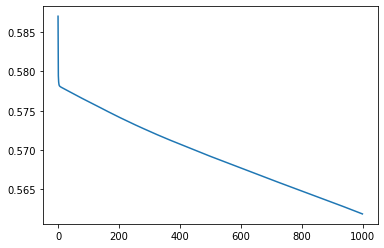

In [530]:
plt.plot(error)

In [531]:
lr = 0.01
energy_history = []
epochs = int(2e4)
Pbar = pkbar.Pbar(name='progress', target=epochs)
op = optim.SGD([data], lr=lr, momentum=0.9, weight_decay=5e-4)

for e in range(epochs):
    op.zero_grad()
    
    new_edges = []
    new_cores = tn.replicate_nodes(combined_cores)
    for j in range(len(combined_cores)):
        edges = new_cores[j].get_all_dangling()
        for edge in edges:
            new_edges.append(edge)
    
    spin = K_Spin(s, a, k, data=data)
    for j in range(k):
        new_edges[j] ^ spin.qubits[j][0]
            
    energy = -contractors.branch(tn.reachable(new_cores[0]), nbranch=1).get_tensor()
    energy.backward()
    energy_history.append(energy)
    
    op.step()
    Pbar.update(e)

progress
20000/20000  [==============================] - 73.5s


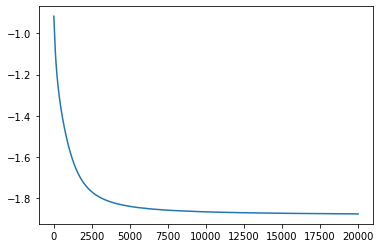

In [532]:
# with plt.style.context(['science', 'notebook']):
plt.plot(energy_history)
plt.title='Policy Iteration using K-Spin Hamiltonian'
plt.xlabel='Number of iterations'
plt.ylabel='Energy'

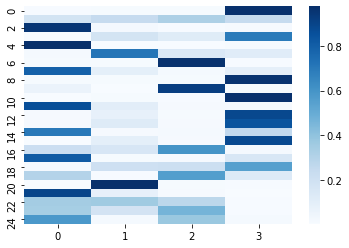

In [533]:
result = spin.data.reshape(s, a).detach().numpy() * 25
ax = sns.heatmap(result, cmap="Blues")
plt.xlabel = 'States'
plt.show()

In [534]:
policy = torch.empty(s)
p = torch.tensor(result)
for i in range(s):
    policy[i] = torch.argmax(p[i, :])
policy.reshape(5, 5)

tensor([[3., 2., 0., 3., 0.],
        [1., 2., 0., 3., 2.],
        [3., 0., 3., 3., 0.],
        [3., 2., 0., 3., 2.],
        [1., 0., 1., 2., 0.]])

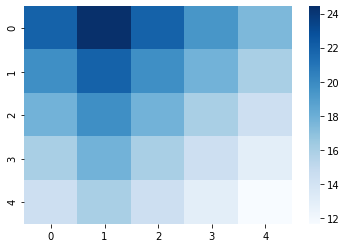

In [497]:
sns.heatmap(target, cmap='Blues')